<a href="https://www.kaggle.com/code/aryandec25/notebook-stackoverflow?scriptVersionId=136324788" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Importing all the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
import re
from wordcloud import WordCloud
from bs4 import BeautifulSoup


from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score,classification_report

In [2]:
!unzip /kaggle/input/facebook-recruiting-iii-keyword-extraction/Train.zip
!unzip /kaggle/input/facebook-recruiting-iii-keyword-extraction/Test.zip

Archive:  /kaggle/input/facebook-recruiting-iii-keyword-extraction/Train.zip
  inflating: Train.csv               
Archive:  /kaggle/input/facebook-recruiting-iii-keyword-extraction/Test.zip
  inflating: Test.csv                


In [3]:
df_train = pd.read_csv('/kaggle/working/Train.csv').sample(500000)
df_test = pd.read_csv('/kaggle/working/Test.csv').sample(50000)

# Exploring the data

In [4]:
print(f'The shape of the Train dataset: {df_train.shape}')
print(f'The shape of the Train dataset: {df_test.shape}')

The shape of the Train dataset: (500000, 4)
The shape of the Train dataset: (50000, 3)


In [5]:
df_train.reset_index(drop = True,inplace=True)

In [6]:
df_train.head()

,Id,Title,Body,Tags
0,5393254,margin changes after jQuery .slidDown() animation,"<p>I created this site at work, <a href=""http:...",javascript jquery website slidedown
1,2911116,Subsite Migration from SharePoint 2007 to Shar...,<p>We want to Migrate a subsite from SharePoin...,2007 migration administration content-deployment
2,2371830,Difficulty in establishing VersionInfo for exi...,<p>I have an extant C++ DLL which compiles pro...,c++ dll resources version versioninfo
3,2730881,Using erldis on ejabberd Module?,<p>I'm working on an ejabberd module that requ...,module redis ejabberd
4,5934132,Executing command line programs from within py...,<blockquote>\n <p><strong>Possible Duplicate:...,python command-line


In [7]:
df_train['Body'][0]

'<p>I created this site at work, <a href="http://eco-spirit.ca/" rel="nofollow">http://eco-spirit.ca/</a>, (the IE version isn\'t done yet, so it\'s best viewed in Chrome/Safari/Firefox), and when you click on the icons at the top I use the .slideDown() method to show a small blurb. It all works the way the boss asked but I noticed right after the animation, the text bumps up about 10-15 pixels, as if the margin is changing. And it does the same when the .slideUp() method is called.</p>\n\n<p>Does anyone know why this would happen?</p>\n\n<p>(ps I didn\'t design this site I just programmed it)</p>\n'

In [8]:
df_train['Tags'][0]

'javascript jquery website slidedown'

In [9]:
print(f'Train DataFrame Shape: {df_train.shape}')

Train DataFrame Shape: (500000, 4)


## Data pre-processing

### Checking for duplicates

In [10]:
duplicated_pairs = df_train.sort_values('Title', ascending=False).duplicated('Title')
print(f'Total number of duplicated questions: {duplicated_pairs.sum()}')

df_train = df_train[~duplicated_pairs]
print(f'Dataframe shape after duplicate removal: {df_train.shape}')


Total number of duplicated questions: 15163
Dataframe shape after duplicate removal: (484837, 4)


In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 484837 entries, 0 to 499999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Id      484837 non-null  int64 
 1   Title   484837 non-null  object
 2   Body    484837 non-null  object
 3   Tags    484837 non-null  object
dtypes: int64(1), object(3)
memory usage: 18.5+ MB


In [12]:
df_train.isnull().sum()

Id       0
Title    0
Body     0
Tags     0
dtype: int64

In [13]:
df_train.dropna(axis=0, inplace=True)

In [14]:
df_train.isnull().sum()

Id       0
Title    0
Body     0
Tags     0
dtype: int64

In [15]:
from pprint import pprint

pprint(df_train.iloc[5].to_dict(), compact=True)

{'Body': "<p>I'm working on a project with a directory structure that relies "
         'on symlinks. I would like to package this project in such a way that '
         'users with no command line access or knowledge could still upload '
         'the project to their servers. At the moment, this is not possible, '
         'whenever I attempt to upload the symlinks, they are converted into '
         'the contents they link to.</p>\n'
         '\n'
         '<p>Is it actually possible to upload symlinks to a server? If yes, '
         'what would be the procedure? If not can you recommend another '
         'approach? </p>\n'
         '\n'
         "<p>This project wouldn't work without symlinks as I need the same "
         'information in various places and copying the content is not an '
         'option.</p>\n'
         '\n'
         '<p>Thanks!!!</p>\n',
 'Id': 1148201,
 'Tags': 'symbolic-link',
 'Title': 'Uploading symlinks to a server'}


#### Creating a tag count column as a new feature

In [16]:
df_train['Tag_Counts'] = df_train['Tags'].apply(lambda x: len(x.split()))

In [17]:
df_train[['Tags','Tag_Counts']]

,Tags,Tag_Counts
0,javascript jquery website slidedown,4
1,2007 migration administration content-deployment,4
2,c++ dll resources version versioninfo,5
3,module redis ejabberd,3
4,python command-line,2
...,...,...
499995,php javascript window.open window.opener,4
499996,ruby osx gem nokogiri,4
499997,file-transfer imaging multicast,3
499998,firefox,1


## Basic Data Analysis on Tags

### Frequency of tag_count

In [18]:
df_train['Tag_Counts'].value_counts()

3    138799
2    129056
4     92611
1     66967
5     57404
Name: Tag_Counts, dtype: int64

In [19]:
print( "Maximum number of tags in a question: ", df_train["Tag_Counts"].max())
print( "Minimum number of tags in a question: ", df_train["Tag_Counts"].min())
print( "Average number of tags in a question: ", df_train["Tag_Counts"].mean())

Maximum number of tags in a question:  5
Minimum number of tags in a question:  1
Average number of tags in a question:  2.885382097488434


In [20]:
df_train

,Id,Title,Body,Tags,Tag_Counts
0,5393254,margin changes after jQuery .slidDown() animation,"<p>I created this site at work, <a href=""http:...",javascript jquery website slidedown,4
1,2911116,Subsite Migration from SharePoint 2007 to Shar...,<p>We want to Migrate a subsite from SharePoin...,2007 migration administration content-deployment,4
2,2371830,Difficulty in establishing VersionInfo for exi...,<p>I have an extant C++ DLL which compiles pro...,c++ dll resources version versioninfo,5
3,2730881,Using erldis on ejabberd Module?,<p>I'm working on an ejabberd module that requ...,module redis ejabberd,3
4,5934132,Executing command line programs from within py...,<blockquote>\n <p><strong>Possible Duplicate:...,python command-line,2
...,...,...,...,...,...
499995,1418289,"Opening search results in new window, then lin...","<p>I'm not the best javascript programmer, so ...",php javascript window.open window.opener,4
499996,3386663,Install Nokogiri without Apple's dev package (...,<p>I'm trying to install Nokogiri on a compute...,ruby osx gem nokogiri,4
499997,1409090,Multicast image restoration with adaptive speed,<p>I'm curious to know if there are any tools ...,file-transfer imaging multicast,3
499998,3388444,How to disable .focus() on FIrefox,<p>I'm using the latest versions of Firefox an...,firefox,1


Something looks odd about this

In [21]:
df_train['Tag_Counts'].value_counts()

3    138799
2    129056
4     92611
1     66967
5     57404
Name: Tag_Counts, dtype: int64

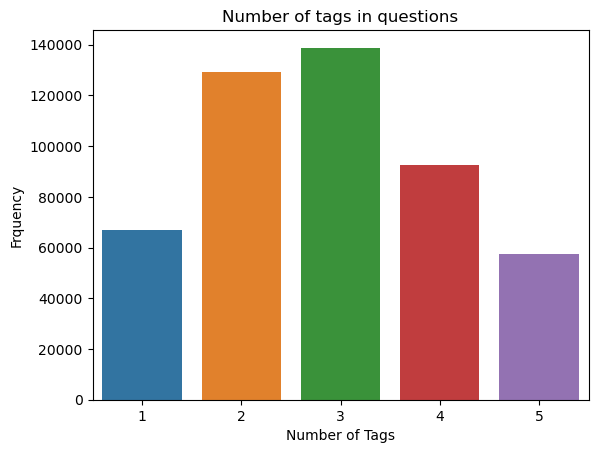

In [22]:
df_train_tag_freq = df_train['Tag_Counts'].value_counts().reset_index().sort_values(by='index').rename(columns = {'index':'tag_count', 'Tag_Counts':'tag_value_counts'})


plt.title('Number of tags in questions')
sns.barplot(data = df_train_tag_freq, x = 'tag_count', y = 'tag_value_counts')
plt.xlabel('Number of Tags')
plt.ylabel('Frquency')
plt.show()

#### Observations: 
1. Maximum number of tags in question: 5
2. Minimum number of tags in question: 1
3. Average number of tags in question: 2.89
4. Most of the questions have either 2 or 3 tags to work with.

### Total number of unique Tags

In [23]:
vectorizer = CountVectorizer(tokenizer = lambda x : x.split())
tag_bow = vectorizer.fit_transform(df_train['Tags'])

In [24]:
tag_bow.shape

(484837, 30449)

In [25]:
print("Number of questions :", tag_bow.shape[0])
print("Number of unique tags :", tag_bow.shape[1])

Number of questions : 484837
Number of unique tags : 30449


In [26]:
tags = vectorizer.get_feature_names_out()
print("Few tags :", tags[:10])

Few tags : ['.a' '.app' '.aspxauth' '.bash-profile' '.class-file' '.doc' '.each'
 '.emf' '.exe' '.exe.config']


In [27]:
df_train.head()

,Id,Title,Body,Tags,Tag_Counts
0,5393254,margin changes after jQuery .slidDown() animation,"<p>I created this site at work, <a href=""http:...",javascript jquery website slidedown,4
1,2911116,Subsite Migration from SharePoint 2007 to Shar...,<p>We want to Migrate a subsite from SharePoin...,2007 migration administration content-deployment,4
2,2371830,Difficulty in establishing VersionInfo for exi...,<p>I have an extant C++ DLL which compiles pro...,c++ dll resources version versioninfo,5
3,2730881,Using erldis on ejabberd Module?,<p>I'm working on an ejabberd module that requ...,module redis ejabberd,3
4,5934132,Executing command line programs from within py...,<blockquote>\n <p><strong>Possible Duplicate:...,python command-line,2


### Frequency of each tag

In [28]:
freq = tag_bow.sum(axis = 0).A1
tag_to_count_map = dict(zip(tags,freq))

In [29]:
freq

array([4, 5, 2, ..., 3, 1, 3])

In [30]:
print(f'Shape of Freqeuency: {freq.shape}')
print(f'Shape of Tags: {tags.shape}')


Shape of Freqeuency: (30449,)
Shape of Tags: (30449,)


In [31]:
list = []
for key, value in tag_to_count_map.items():
  list.append([key, value]) 


tag_df_train = pd.DataFrame(list, columns=['Tags', 'Counts'])
tag_df_train.head()

,Tags,Counts
0,.a,4
1,.app,5
2,.aspxauth,2
3,.bash-profile,17
4,.class-file,7


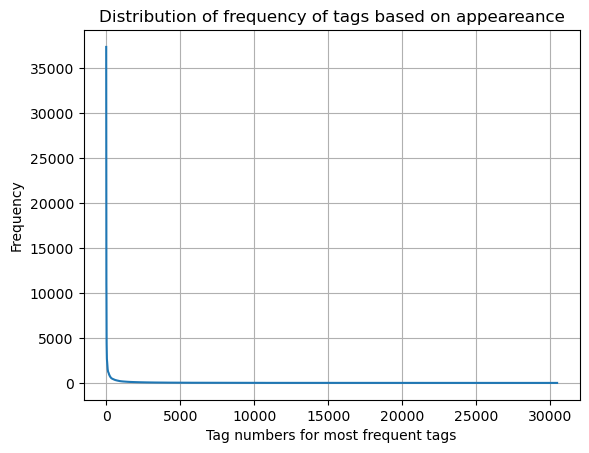

In [32]:
tag_df_train_sorted = tag_df_train.sort_values(['Counts'], ascending=False)
plt.plot(tag_df_train_sorted['Counts'].values)
plt.grid()
plt.title("Distribution of frequency of tags based on appeareance")
plt.xlabel("Tag numbers for most frequent tags")
plt.ylabel("Frequency")
plt.show()

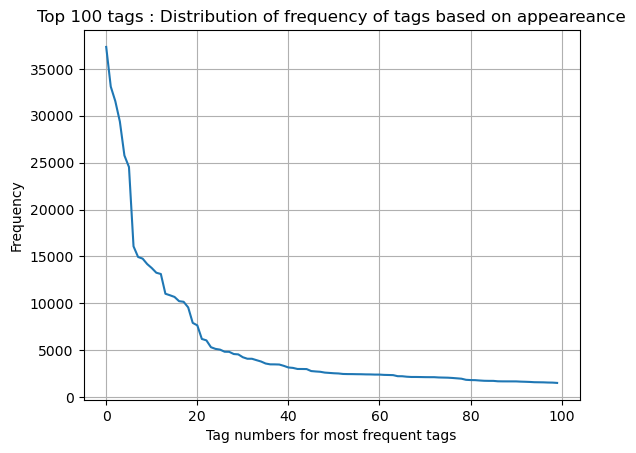

In [33]:
plt.plot(tag_df_train_sorted['Counts'][0:100].values)
plt.grid()
plt.title("Top 100 tags : Distribution of frequency of tags based on appeareance")
plt.xlabel("Tag numbers for most frequent tags")
plt.ylabel("Frequency")
plt.show()

In [34]:
tag_bow

<484837x30449 sparse matrix of type '<class 'numpy.int64'>'
	with 1398940 stored elements in Compressed Sparse Row format>

Data pre-processing

- Cleaning up the title and body
- realtion with name of the tag and title or body
- Present of code snippet based on body. 
- Length of the body
- if any attachment  with the questions. 
- Url attachments
- Synonymn of tags in title or body.


In [35]:
df_train

,Id,Title,Body,Tags,Tag_Counts
0,5393254,margin changes after jQuery .slidDown() animation,"<p>I created this site at work, <a href=""http:...",javascript jquery website slidedown,4
1,2911116,Subsite Migration from SharePoint 2007 to Shar...,<p>We want to Migrate a subsite from SharePoin...,2007 migration administration content-deployment,4
2,2371830,Difficulty in establishing VersionInfo for exi...,<p>I have an extant C++ DLL which compiles pro...,c++ dll resources version versioninfo,5
3,2730881,Using erldis on ejabberd Module?,<p>I'm working on an ejabberd module that requ...,module redis ejabberd,3
4,5934132,Executing command line programs from within py...,<blockquote>\n <p><strong>Possible Duplicate:...,python command-line,2
...,...,...,...,...,...
499995,1418289,"Opening search results in new window, then lin...","<p>I'm not the best javascript programmer, so ...",php javascript window.open window.opener,4
499996,3386663,Install Nokogiri without Apple's dev package (...,<p>I'm trying to install Nokogiri on a compute...,ruby osx gem nokogiri,4
499997,1409090,Multicast image restoration with adaptive speed,<p>I'm curious to know if there are any tools ...,file-transfer imaging multicast,3
499998,3388444,How to disable .focus() on FIrefox,<p>I'm using the latest versions of Firefox an...,firefox,1


In [36]:
df_train['Body'][1]

'<p>We want to Migrate a subsite from SharePoint 2007 to SharePoint 2010 without doing a content DB Migration, we tried with "import/export" commands and failed. </p>\n\n<p>Please let me know if we have any other easy way of doing this ?</p>\n\n<p>May be using Powershell or custom code...</p>\n'

In [37]:
tag_df_train_sorted

,Tags,Counts
3183,c#,37335
13158,java,33108
19724,php,31552
13221,javascript,29380
907,android,25762
...,...,...
16631,mpic++,1
7507,duply,1
12930,irix,1
18537,opencpu,1


In [38]:
print("{} tags are used more than 25 times".format(tag_df_train_sorted[tag_df_train_sorted["Counts"]>25].shape[0]))
print("{} tags are used more than 50 times".format(tag_df_train_sorted[tag_df_train_sorted["Counts"]>50].shape[0]))

4944 tags are used more than 25 times
3061 tags are used more than 50 times


### Observations:
1. 144 tags are used more than 25 times.
2. 59 tags are used more than 50 times.
3. C# is most frequently used tag 778 times.
4. Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate metric for this probelm.

## Word map

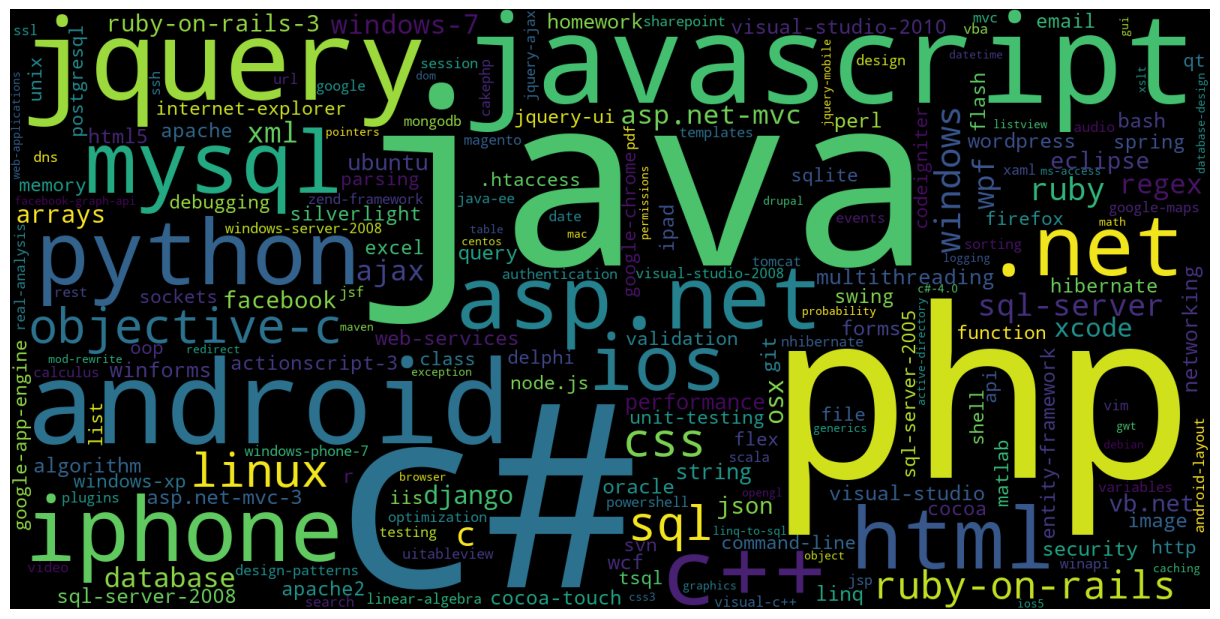

In [39]:
tag_to_count_map
tupl = dict(tag_to_count_map.items())
word_cloud = WordCloud(width=1600,height=800,).generate_from_frequencies(tupl)
plt.figure(figsize = (12,8))
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

### Barplot of top 20 tags

In [40]:
tag_df_train_sorted.reset_index(drop=True)

,Tags,Counts
0,c#,37335
1,java,33108
2,php,31552
3,javascript,29380
4,android,25762
...,...,...
30444,mpic++,1
30445,duply,1
30446,irix,1
30447,opencpu,1


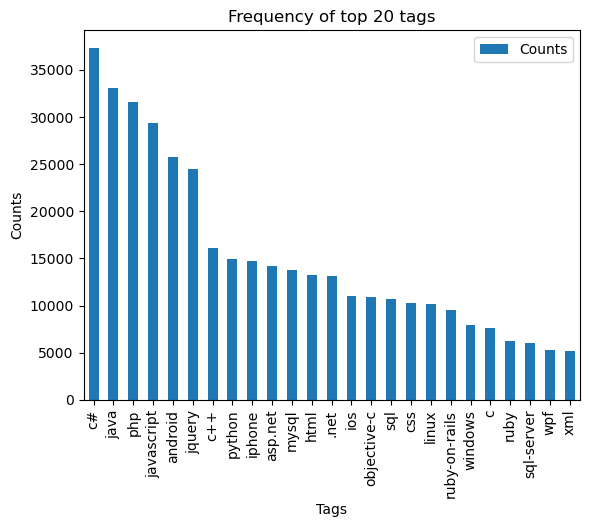

In [41]:
i=np.arange(25)
tag_df_train_sorted.head(25).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_train_sorted['Tags'].head(25))
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

In [42]:
print("{} tags are used more than 25 times".format(tag_df_train_sorted[tag_df_train_sorted["Counts"]>25].shape[0]))
print("{} tags are used more than 50 times".format(tag_df_train_sorted[tag_df_train_sorted["Counts"]>50].shape[0]))

4944 tags are used more than 25 times
3061 tags are used more than 50 times


In [43]:
tag_df_train_sorted['Tags']

3183             c#
13158          java
19724           php
13221    javascript
907         android
            ...    
16631        mpic++
7507          duply
12930          irix
18537       opencpu
24620       spgroup
Name: Tags, Length: 30449, dtype: object

<Axes: xlabel='Body_Length', ylabel='Tag_Counts'>

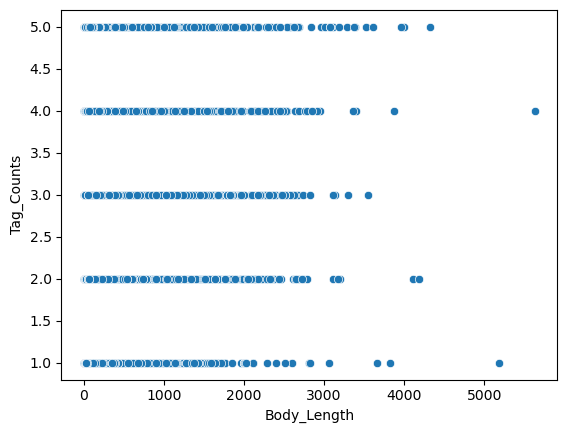

In [44]:
df_train['Body_Length'] = df_train['Body'].apply(lambda x : len(x.split()))
sns.scatterplot(x= df_train['Body_Length'], y = df_train['Tag_Counts'])

<Axes: xlabel='Title_Length', ylabel='Tag_Counts'>

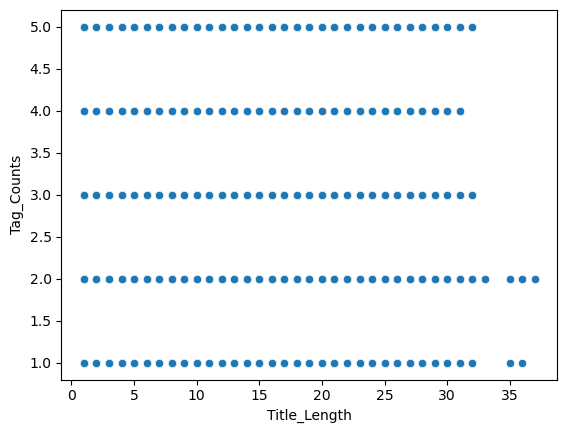

In [45]:
df_train['Title_Length'] = df_train['Title'].apply(lambda x : len(x.split()))
sns.scatterplot(x= df_train['Title_Length'], y = df_train['Tag_Counts'])

## Text preprocessing

In [46]:
def find_code(df):
    if '<code>' in df:
        return 1
    else: 
        return 0

    
df_train['is_code'] = df_train['Body'].apply(find_code)

In [47]:
df_train

,Id,Title,Body,Tags,Tag_Counts,Body_Length,Title_Length,is_code
0,5393254,margin changes after jQuery .slidDown() animation,"<p>I created this site at work, <a href=""http:...",javascript jquery website slidedown,4,97,6,0
1,2911116,Subsite Migration from SharePoint 2007 to Shar...,<p>We want to Migrate a subsite from SharePoin...,2007 migration administration content-deployment,4,48,8,0
2,2371830,Difficulty in establishing VersionInfo for exi...,<p>I have an extant C++ DLL which compiles pro...,c++ dll resources version versioninfo,5,236,9,1
3,2730881,Using erldis on ejabberd Module?,<p>I'm working on an ejabberd module that requ...,module redis ejabberd,3,44,5,0
4,5934132,Executing command line programs from within py...,<blockquote>\n <p><strong>Possible Duplicate:...,python command-line,2,149,7,1
...,...,...,...,...,...,...,...,...
499995,1418289,"Opening search results in new window, then lin...","<p>I'm not the best javascript programmer, so ...",php javascript window.open window.opener,4,145,11,1
499996,3386663,Install Nokogiri without Apple's dev package (...,<p>I'm trying to install Nokogiri on a compute...,ruby osx gem nokogiri,4,183,7,1
499997,1409090,Multicast image restoration with adaptive speed,<p>I'm curious to know if there are any tools ...,file-transfer imaging multicast,3,311,6,0
499998,3388444,How to disable .focus() on FIrefox,<p>I'm using the latest versions of Firefox an...,firefox,1,25,6,0


In [48]:
print(f"There are a total of {df_train[df_train['is_code'] == 1].shape[0]} questions with code out of {df_train.shape[0]}")
print(f"{np.round((100 * df_train[df_train['is_code'] == 1].shape[0])/df_train.shape[0],2)}% of the questions has code")

There are a total of 272441 questions with code out of 484837
56.19% of the questions has code


In [49]:
# Top 30 tags used in our corpus
list_tags = tag_df_train_sorted['Tags'].head(20).to_list()

# Filtering by only those rows where the tags are in top 30
df_tags = df_train[(df_train['Tags'].isin(list_tags))][['Title','Body', 'Tags']]

# Using the title and body as one column.
df_tags['post'] = df_tags['Title'] + ' ' + df_tags['Body']

# Removing extra columns.
df_tags = df_tags.drop('Title', axis = 1).drop('Body', axis = 1)

df_tags.head(2)

,Tags,post
32,php,PHP template string replace <p>just wondering ...
44,c++,copy constructor for a linked list classes <p>...


In [50]:
print('Original Df length: \t' + str(len(df_train)))
len_df_tags = len(df_tags)
print('df tags length: \t' + str(len_df_tags))

Original Df length: 	484837
df tags length: 	23823


In [51]:
%%time
en_stopwords = stopwords.words('english')

# HTML decoding.
df_tags['post'] = df_tags['post'].apply(lambda x: (BeautifulSoup(x, 'lxml').text).lower())

# Replacingsymbols by space in text.
df_tags['post'] = df_tags['post'].str.replace('[/(){}\[\]\|@,;]', ' ', regex=True)

# Deletting symbols from text.
df_tags['post'] = df_tags['post'].str.replace('[^0-9a-z #+_]', '', regex=True)

# Deleting stop words.
df_tags['post'] = df_tags['post'].apply(lambda x: ' '.join([word for word in x.split() if word not in (en_stopwords)]))

df_tags.head(5)

CPU times: user 21.2 s, sys: 2.14 ms, total: 21.2 s
Wall time: 21.2 s


,Tags,post
32,php,php template string replace wondering whats be...
44,c++,copy constructor linked list classes want copy...
45,android,android screen never turns problem android app...
69,iphone,reload uipicker elements iphone seen many appl...
83,javascript,x foo saw somewhere else said x foo equal toif...


In [52]:
df_tags['post'].iloc[1]

'copy constructor linked list classes want copy whole linked list classes trouble figuring class list public list const list private struct node int x node next p started something like thislistlist const list node q qnew node pnull qx px im sure right track also trouble test copy constructor example list l1 insert couple integers list copy'

In [53]:
i = 0
for items in df_tags['post']:
    print(items)
    print('------------------------------------------------------------------------------')
    
    i += 1
    
    if i > 10:
        break

php template string replace wondering whats best approach template string replacepreg_replace s+ bill tableoutput preg_replace lots string needs replace function called many times depend number string needs replace wondering way look though string replace accordinglythanks
------------------------------------------------------------------------------
copy constructor linked list classes want copy whole linked list classes trouble figuring class list public list const list private struct node int x node next p started something like thislistlist const list node q qnew node pnull qx px im sure right track also trouble test copy constructor example list l1 insert couple integers list copy
------------------------------------------------------------------------------
android screen never turns problem android app doesnt seem let screen turn ever could cause isnt screen supposed turn depending users settingsthanks help
------------------------------------------------------------------------

## ML Modeling

### Splitting the data for Train Test Split

In [54]:
X = df_tags.post
y = df_tags.Tags
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [55]:
X_train

181862    client side data binding possible aspnet 40 pl...
323716    simple sql question getting rows associated co...
458820    safe way allow 3rdparty javascript page safe w...
211925    add value 3 arrays one array 3 arrays meat veg...
182213    php array processing question write function b...
                                ...                        
451542    string constant delimiters dont banalize line ...
111128    get products warehouse exist question title wa...
17427     con one suggest best android video tutorial po...
329740    code paths return value error quickselect meth...
495965    returning const pointer const pointer classs o...
Name: post, Length: 16676, dtype: object

### 1. Naive Bayes Classifier

In [56]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [57]:
%%time
y_pred = nb.predict(X_test)

accuracy_Naive_Bayes = accuracy_score(y_pred, y_test)
print('accuracy %s' % accuracy_Naive_Bayes)
print(classification_report(y_test, y_pred,target_names=list_tags))

accuracy 0.42563313278298587
               precision    recall  f1-score   support

           c#       0.00      0.00      0.00        48
         java       0.26      1.00      0.42      1172
          php       1.00      0.03      0.06       303
   javascript       0.78      0.09      0.17       575
      android       0.97      0.27      0.42       383
       jquery       1.00      0.06      0.12       178
          c++       0.00      0.00      0.00        75
       python       0.00      0.00      0.00        76
       iphone       0.79      0.06      0.11       311
      asp.net       0.82      0.21      0.33       597
        mysql       0.91      0.38      0.54       639
         html       0.64      0.87      0.74       667
         .net       0.00      0.00      0.00        68
          ios       0.78      0.23      0.36       368
  objective-c       0.00      0.00      0.00       110
          sql       0.58      0.78      0.66       749
          css       1.00      0.12 

## Linear SVM

In [58]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [59]:
%%time

y_pred = sgd.predict(X_test)

accuracy_Linear_SVM = accuracy_score(y_pred, y_test)
print('accuracy %s' % accuracy_Linear_SVM)
print(classification_report(y_test, y_pred,target_names=list_tags))

accuracy 0.7891422974674689
               precision    recall  f1-score   support

           c#       0.57      0.17      0.26        48
         java       0.75      0.98      0.85      1172
          php       0.84      0.72      0.77       303
   javascript       0.79      0.37      0.51       575
      android       0.79      0.73      0.76       383
       jquery       0.85      0.78      0.82       178
          c++       0.67      0.03      0.05        75
       python       0.73      0.21      0.33        76
       iphone       0.78      0.67      0.72       311
      asp.net       0.77      0.82      0.80       597
        mysql       0.82      0.80      0.81       639
         html       0.78      0.95      0.86       667
         .net       0.82      0.53      0.64        68
          ios       0.73      0.95      0.83       368
  objective-c       0.78      0.41      0.54       110
          sql       0.79      0.92      0.85       749
          css       0.88      0.92  

## Logistic Regression

In [60]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5, solver='liblinear')),
               ])
logreg.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 LogisticRegression(C=100000.0, n_jobs=1, solver='liblinear'))])

In [61]:
%%time

y_pred = logreg.predict(X_test)

accuracy_Logistic_Reg = accuracy_score(y_pred, y_test)
print('accuracy %s' % accuracy_Logistic_Reg)
print(classification_report(y_test, y_pred,target_names=list_tags))

accuracy 0.8140478522456975
               precision    recall  f1-score   support

           c#       0.55      0.25      0.34        48
         java       0.91      0.95      0.93      1172
          php       0.81      0.76      0.78       303
   javascript       0.62      0.63      0.62       575
      android       0.74      0.75      0.75       383
       jquery       0.84      0.84      0.84       178
          c++       0.59      0.40      0.48        75
       python       0.58      0.33      0.42        76
       iphone       0.73      0.74      0.73       311
      asp.net       0.81      0.81      0.81       597
        mysql       0.82      0.82      0.82       639
         html       0.86      0.93      0.89       667
         .net       0.79      0.68      0.73        68
          ios       0.83      0.87      0.85       368
  objective-c       0.66      0.55      0.60       110
          sql       0.82      0.87      0.85       749
          css       0.93      0.89  

In [62]:
df_results = pd.DataFrame([{'Naive Bayes Classifier for Multinomial Models':accuracy_Naive_Bayes, 'Linear support vector machine':accuracy_Linear_SVM, 'Logistic regression':accuracy_Logistic_Reg}]).T
df_results = df_results.rename({0:'Accuracy'}, axis=1)
df_results = df_results.sort_values(by='Accuracy', ascending=False)

display(df_results)

,Accuracy
Logistic regression,0.814048
Linear support vector machine,0.789142
Naive Bayes Classifier for Multinomial Models,0.425633


________________